In [3]:
import matplotlib.pyplot as plt
from autograd import grad, hessian
import math
import autograd.numpy as np

# Functions we will minimize

In [4]:
def rosenbrock(x):
    return 100 * (x[1] - x[0]**2)**2 + (1 - x[0])**2

In [5]:
def euclidean_norm(x):
    return np.sqrt(np.sum(np.array([x1**2 for x1 in x])))

In [6]:
def multidim_func(x):
    return np.sum(np.array(x+5)**4)

In [7]:
def multidim_func2(x):
    n = int(len(x)/2)
    return np.sum(np.array(x+5)**4) + np.sum(np.array(x[0:n]+5)**2)

## Stepsize selection

In [8]:
def F_k(alpha, xk, grad_hess, func=rosenbrock):
    return func(xk - alpha*grad_hess)

In [9]:
def davies_swann_campey(x0, delta0, epsilon, K, xk, grad_hess, func_min=rosenbrock):
    i = 1
    while delta0 > epsilon and i:
        delta = delta0
        f_x0 = F_k(x0, xk, grad_hess, func_min)
        f_x0_min_delta = F_k(x0 - delta, xk, grad_hess, func_min)
        f_x0_plus_delta = F_k(x0 + delta, xk, grad_hess, func_min)
        if f_x0 < f_x0_min_delta and f_x0 < f_x0_plus_delta:
            a = x0 - delta
            b = x0 + delta
            c = x0
            i = 0
        else:
            d = -1 if f_x0_min_delta < f_x0_plus_delta else 1
            x0 = x0 - d*delta
            f1 = F_k(x0 + d*delta, xk, grad_hess, func_min)
            f2 = F_k(x0 + 2*d*delta, xk, grad_hess, func_min)
            while f2 <= f1 and math.isfinite(delta):
                delta *= 2
                f1 = f2
                f2 = F_k(x0 + 2*d*delta, xk, grad_hess, func_min)
            if math.isfinite(delta):
                c = x0 + d*delta
                a = c - delta
                b = c + delta
                i = 0
            else:
                delta0 = K * delta0

    return a, b, c         

In [10]:
def quadratic_interpolation(xk, grad_hess, func_min=rosenbrock, epsilon=0.0001, max_steps=100):
    x0 = 0
    delta0 = 0.1
    K = 0.1
    a, b, c = davies_swann_campey(x0, delta0, epsilon, K, xk, grad_hess, func_min)
    fa = F_k(a, xk, grad_hess, func_min)
    fb = F_k(b, xk, grad_hess, func_min)
    fc = F_k(c, xk, grad_hess, func_min)
    alpha = b + epsilon
    alpha_line = c
    iterator = 0
    while abs(alpha-alpha_line) > epsilon and iterator < max_steps:
        alpha = alpha_line
        alpha_line = ((b**2 - c**2)*fa + (c**2 - a**2)*fb + (a**2 - b**2)*fc) \
                     / (2*((b - c)*fa + (c - a)*fb + (a - b)*fc))
        if alpha_line > c:
            d = alpha_line
        else:
            d = c
            c = alpha_line
        fc = F_k(c, xk, grad_hess, func_min)
        fd = F_k(d, xk, grad_hess, func_min)
        if fc < fd:
            b = d
            fb = F_k(b, xk, grad_hess, func_min)
        else:
            a = c
            c = d
            fa = F_k(a, xk, grad_hess, func_min)
            fc = F_k(c, xk, grad_hess, func_min)
        iterator += 1
    return alpha_line



## Newton's method

In [11]:
def newtons_method(func, x0, epsilon, epsilon_qi=0.00001):
    gradient = grad(func)
    hess = hessian(func)
 
    prev_f = func(x0)
    x = x0

    iterator = 0
    accuracy_reached = False
    while not accuracy_reached:
        gradient_val = gradient(np.array(x, dtype=float))
        hessian_val = hess(np.array(x, dtype=float))
        grad_hess = np.linalg.inv(hessian_val)@gradient_val

        stepsize = quadratic_interpolation(x, grad_hess, func_min=func, epsilon=epsilon_qi)
        x = x - stepsize*grad_hess
        current_f = func(x)

        if abs(current_f-prev_f) < epsilon:
            break
        prev_f = current_f
        iterator += 1

    return x, current_f, iterator

## Powell's method

In [12]:
def orthogonal_basis(n):
    basis = list(np.zeros(n))
    for i in range(n):
        vec = np.zeros(n)
        vec[i] = 1
        basis[i] = vec
    return basis

In [91]:
def powell_method(func, x0, epsilon, epsilon_qi=0.00001):
    n = len(x0)
    directions = orthogonal_basis(n)
    xk = x0
    accuracy_reached = False
    iterator = 0
    while not accuracy_reached:
        xs = list(np.zeros(n))
        xs[0] = xk
        for i in range(1, n):
            alpha = quadratic_interpolation(xk, -directions[i-1], func_min=func, epsilon=epsilon_qi)
            xk = xs[i-1] + alpha*directions[i-1]
            xs[i] = xk
        directions.pop(0)
        directions.append(xs[-1] - xs[0])
        new_alpha = quadratic_interpolation(xs[0], -directions[-1], func_min=func, epsilon=epsilon_qi)
        xs.append(xs[0] + new_alpha*directions[-1])
        if np.linalg.norm(new_alpha*directions[-1]) < epsilon:
            fk = func(xs[-1])
            return xs[-1], fk, iterator
        xk = xs[-1]
        iterator += 1

In [74]:
%%time
minimizer, f_val, iterations = newtons_method(rosenbrock, [5, 3], 10**(-5))

CPU times: total: 0 ns
Wall time: 51.3 ms


In [75]:
print(rf"Minimizer x obtained by Newtons method: {minimizer}")
print(rf"Value of function at x: {f_val}")
print(rf"Number of iterations: {iterations}")

Minimizer x obtained by Newtons method: [1.00000046 1.00000097]
Value of function at x: 4.3103869163671994e-13
Number of iterations: 16


In [64]:
%%time
minimizer, f_val, iterations = powell_method(rosenbrock, [5, 3], 10**(-5))

CPU times: total: 93.8 ms
Wall time: 500 ms


In [65]:
print(rf"Minimizer x obtained by Powells method: {minimizer}")
print(rf"Value of function at x: {f_val}")
print(rf"Number of iterations: {iterations}")

Minimizer x obtained by Powells method: [0.99604081 0.99207743]
Value of function at x: 1.571465766428807e-05
Number of iterations: 3846


In [81]:
x0 = np.random.randint(1, 10, size=100)

In [86]:
def multidim_func2(x):
    n = int(len(x)/2)
    return np.sum(np.array(x+2)**4) + np.sum(np.array(x[n+1:-1]+2)**2)

In [95]:
%%time
minimizer, f_val, iterations = newtons_method(multidim_func2, x0, 0.0001, epsilon_qi=0.01)

CPU times: total: 781 ms
Wall time: 272 ms


In [96]:
print(rf"Minimizer x obtained by Newtons method: {minimizer}")
print(rf"Value of function at x: {f_val}")
print(rf"Number of iterations: {iterations}")

Minimizer x obtained by Newtons method: [-1.98707716 -1.97969268 -1.9907694  -1.99446164 -1.98523104 -1.98892328
 -1.98892328 -1.98523104 -1.9815388  -1.99261552 -1.98892328 -1.9815388
 -1.99446164 -1.99446164 -1.98338492 -1.97969268 -1.99446164 -1.9815388
 -1.99446164 -1.99446164 -1.9907694  -1.98338492 -1.98892328 -1.9907694
 -1.98707716 -1.9815388  -1.98523104 -1.9815388  -1.98892328 -1.98892328
 -1.99446164 -1.97969268 -1.97969268 -1.99446164 -1.98707716 -1.99446164
 -1.99446164 -1.99446164 -1.97969268 -1.9907694  -1.98892328 -1.97969268
 -1.97969268 -1.98523104 -1.98892328 -1.98523104 -1.97969268 -1.98338492
 -1.98523104 -1.97969268 -1.98892328 -2.00021132 -1.99986133 -2.00009018
 -1.99995836 -1.99986133 -1.99995836 -1.99985992 -1.99985992 -2.00009018
 -1.99986133 -1.99986133 -2.00002104 -1.99995836 -1.99990437 -1.99990437
 -1.99986133 -1.99985992 -2.00015964 -1.99985992 -1.99995836 -2.00021132
 -1.99995836 -2.00021132 -2.00021132 -1.99986133 -2.00002104 -1.99985992
 -2.00009018 -

In [94]:
%%time
minimizer, f_val, iterations = powell_method(multidim_func2, x0, 0.0001, epsilon_qi=0.01)

CPU times: total: 46.9 ms
Wall time: 196 ms


In [90]:
print(rf"Minimizer x obtained by Powells method: {minimizer}")
print(rf"Value of function at x: {f_val}")
print(rf"Number of iterations: {iterations}")

Minimizer x obtained by Powells method: [-1.98599648 -2.00274977 -2.00059471 -1.99989648 -2.00203671 -2.00120749
 -2.00120749 -2.00137233 -2.00223628 -1.99980399 -2.00120751 -2.00224321
 -1.99989648 -1.99989648 -2.00181519 -2.00232788 -1.99989648 -2.00223392
 -1.99989661 -1.99989661 -2.0005079  -2.00210827 -2.0012075  -2.00050793
 -2.00100842 -2.0022432  -2.00190968 -2.00224544 -2.00120749 -2.0012075
 -1.99989657 -2.00232783 -2.00232783 -1.99989644 -2.00098188 -1.99989653
 -1.99989657 -1.99989669 -2.00232782 -1.99976008 -2.00120751 -2.00232783
 -2.00232782 -2.00137231 -2.0012075  -2.00176121 -2.00232781 -2.00094642
 -2.00137232 -2.00232783 -2.0012075  -1.9999877  -2.00006693 -1.99998887
 -1.99999527 -2.00006693 -1.99999527 -2.00000116 -2.00000116 -1.99998887
 -2.00006693 -2.00006693 -1.9999901  -1.99999527 -2.00000153 -2.00000153
 -2.00006693 -2.00000116 -1.9999851  -2.00000116 -1.99999527 -1.9999877
 -1.99999527 -1.9999877  -1.9999877  -2.00006693 -1.9999901  -2.00000116
 -1.99998887 

In [162]:
%%time
minimizer, f_val, iterations = newtons_method(euclidean_norm, x0, 0.001, epsilon_qi=0.001)

CPU times: total: 12.9 s
Wall time: 12.9 s


In [163]:
print(rf"Minimizer x obtained by Newtons method: {minimizer}")
print(rf"Value of function at x: {f_val}")
print(rf"Number of iterations: {iterations}")

Minimizer x obtained by Newtons method: [4.77143114e-05 1.59047705e-05 3.18095409e-05 7.95238524e-06
 3.97619262e-05 7.95238524e-06 5.56666966e-05 3.18095409e-05
 1.59047705e-05 2.38571557e-05 1.59047705e-05 6.36190819e-05
 1.59047705e-05 3.18095409e-05 5.56666966e-05 2.38571557e-05
 5.56666966e-05 5.56666966e-05 5.56666966e-05 5.56666966e-05
 6.36190819e-05 4.77143114e-05 3.18095409e-05 7.15714671e-05
 6.36190819e-05 6.36190819e-05 3.97619262e-05 1.59047705e-05
 5.56666966e-05 3.18095409e-05 7.95238524e-06 4.77143114e-05
 2.38571557e-05 3.18095409e-05 5.56666966e-05 1.59047705e-05
 3.18095409e-05 1.59047705e-05 3.18095409e-05 5.56666966e-05
 6.36190819e-05 3.97619262e-05 1.59047705e-05 1.59047705e-05
 3.97619262e-05 5.56666966e-05 5.56666966e-05 1.59047705e-05
 7.95238524e-06 1.59047705e-05 1.59047705e-05 4.77143114e-05
 5.56666966e-05 3.97619262e-05 7.15714671e-05 6.36190819e-05
 5.56666966e-05 6.36190819e-05 2.38571557e-05 4.77143114e-05
 5.56666966e-05 1.59047705e-05 7.95238524e-06

In [13]:
%%time
minimizer, f_val, iterations = powell_method(euclidean_norm, x0, 0.001, epsilon_qi=0.001)

CPU times: total: 516 ms
Wall time: 1.52 s


In [14]:
print(rf"Minimizer x obtained by Newtons method: {minimizer}")
print(rf"Value of function at x: {f_val}")
print(rf"Number of iterations: {iterations}")

Minimizer x obtained by Newtons method: [ 6.46743486e-03 -2.99381797e-04 -1.96345474e-04  5.24424957e-06
 -5.08169921e-05 -3.38533320e-05 -1.69084934e-05 -2.82042426e-05
 -4.51610554e-05 -1.12747787e-05 -5.63505332e-06 -3.38542976e-05
 -2.25745619e-05 -5.08199126e-05 -1.12752166e-05 -1.12752294e-05
 -5.08208720e-05 -3.38558345e-05 -1.12756255e-05 -3.95088934e-05
 -5.63544555e-06 -2.25780016e-05 -1.12758607e-05 -4.51648293e-05
 -5.08236341e-05 -1.12763778e-05 -3.38576147e-05 -5.08249543e-05
 -4.51673338e-05 -3.95122625e-05 -3.38591773e-05 -3.38594196e-05
 -2.82094078e-05 -2.82095291e-05 -2.25618811e-05 -1.69088193e-05
 -3.95137936e-05 -4.51702446e-05 -2.25625373e-05 -2.25626135e-05
 -2.25626898e-05 -1.12785531e-05 -3.38612458e-05 -1.69083304e-05
 -2.82110829e-05 -1.12789063e-05 -2.82112638e-05 -4.51722590e-05
 -2.82117791e-05 -3.38630080e-05 -5.08323996e-05 -3.38638434e-05
 -2.25644227e-05 -1.12805107e-05 -3.95181610e-05 -1.12808646e-05
 -4.51752449e-05 -1.12813560e-05 -5.08351118e-05 -

## Plots try

In [166]:
def rosenbrock_xy(x, y):
    return 100 * (y - x**2)**2 + (1 - x)**2

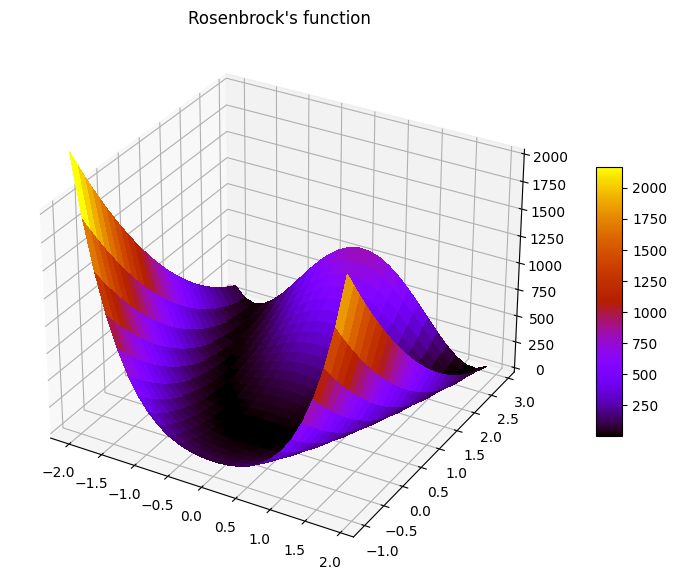

In [175]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(projection = '3d')

X = np.arange(-2, 2, 0.15)
Y = np.arange(-1, 3, 0.15)
X, Y = np.meshgrid(X, Y)
Z = rosenbrock_xy(X,Y)

surf = ax.plot_surface(X, Y, Z, cmap='gnuplot',
                       linewidth=0, antialiased=False)
ax.set_zlim(0, 2000)
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.title("Rosenbrock's function")
plt.show()

First few directions of Powell's method

In [168]:
def newtons_method_with_dir(func, x0, epsilon, epsilon_qi=0.00001):
    gradient = grad(func)
    hess = hessian(func)
 
    prev_f = func(x0)
    x = x0

    xs = [x0]
    iterator = 0
    accuracy_reached = False
    while not accuracy_reached:
        gradient_val = gradient(np.array(x, dtype=float))
        hessian_val = hess(np.array(x, dtype=float))
        grad_hess = np.linalg.inv(hessian_val)@gradient_val

        stepsize = quadratic_interpolation(x, grad_hess, func_min=func, epsilon=epsilon_qi)
        x = x - stepsize*grad_hess
        current_f = func(x)

        if abs(current_f-prev_f) < epsilon:
            break
        prev_f = current_f
        iterator += 1
        xs.append(x)

    return x, current_f, iterator, xs

In [169]:
def powell_method_with_dir(func, x0, epsilon, epsilon_qi=0.00001):
    n = len(x0)
    directions = orthogonal_basis(n)
    xk = x0
    accuracy_reached = False
    iterator = 0
    xks = [x0]
    while not accuracy_reached:
        xs = list(np.zeros(n))
        xs[0] = xk
        for i in range(1, n):
            alpha = quadratic_interpolation(xk, -directions[i-1], func_min=func, epsilon=epsilon_qi)
            xk = xs[i-1] + alpha*directions[i-1]
            xs[i] = xk
        directions.pop(0)
        directions.append(xs[-1] - xs[0])
        new_alpha = quadratic_interpolation(xs[0], -directions[-1], func_min=func, epsilon=epsilon_qi)
        xs.append(xs[0] + new_alpha*directions[-1])
        if np.linalg.norm(new_alpha*directions[-1]) < epsilon:
            fk = func(xs[-1])
            return xs[-1], fk, iterator, xks
        xk = xs[-1]
        xks.append(xk)
        iterator += 1

In [170]:
x0 = [1.7, 2.6]

In [171]:
min_newton, _, it, xs_newton = newtons_method_with_dir(rosenbrock, x0, 10**(-6), epsilon_qi=0.00001)

In [172]:
min_powell, _, it, xs_powell = powell_method_with_dir(rosenbrock, x0, 10**(-6), epsilon_qi=0.00001)

Text(0, 0.5, '$x_2$')

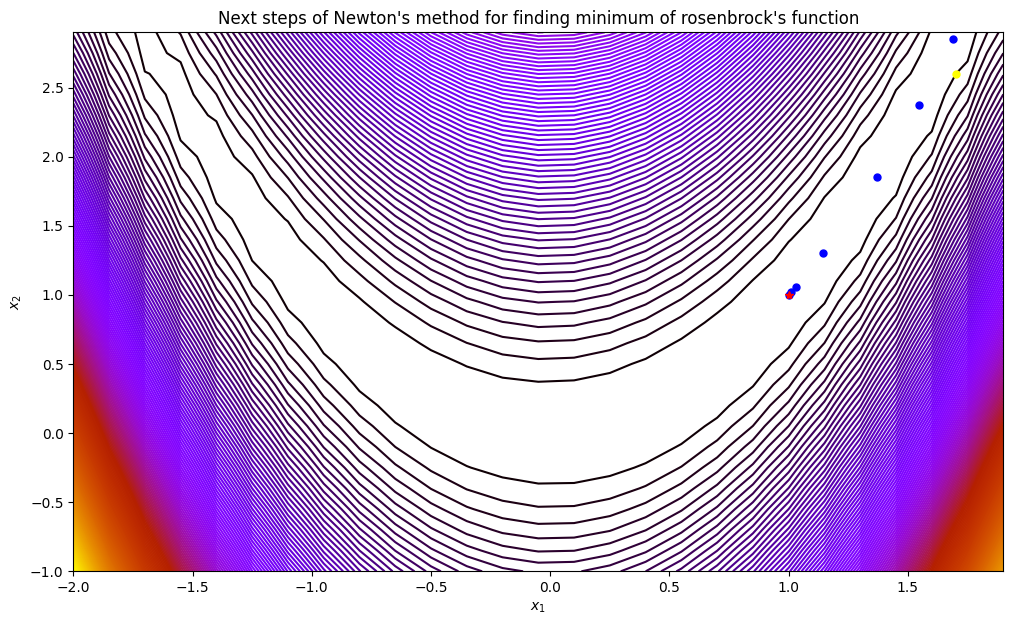

In [173]:
plt.figure(figsize=(12, 7))
plt.contour(X,Y,Z,200, cmap='gnuplot')
plt.plot([x0[0]],[x0[1]], marker='o',markersize=5, color ='yellow')
for i in range(1, len(xs_newton)):
    plt.plot([xs_newton[i][0]],[xs_newton[i][1]], marker='o',markersize=5, color ='blue')
plt.plot([min_newton[0]], [min_newton[1]], marker='*', markersize=6, color='red')
plt.title("Next steps of Newton's method for finding minimum of rosenbrock's function")
plt.xlabel(rf"$x_1$")
plt.ylabel(rf"$x_2$")

Text(0, 0.5, '$x_2$')

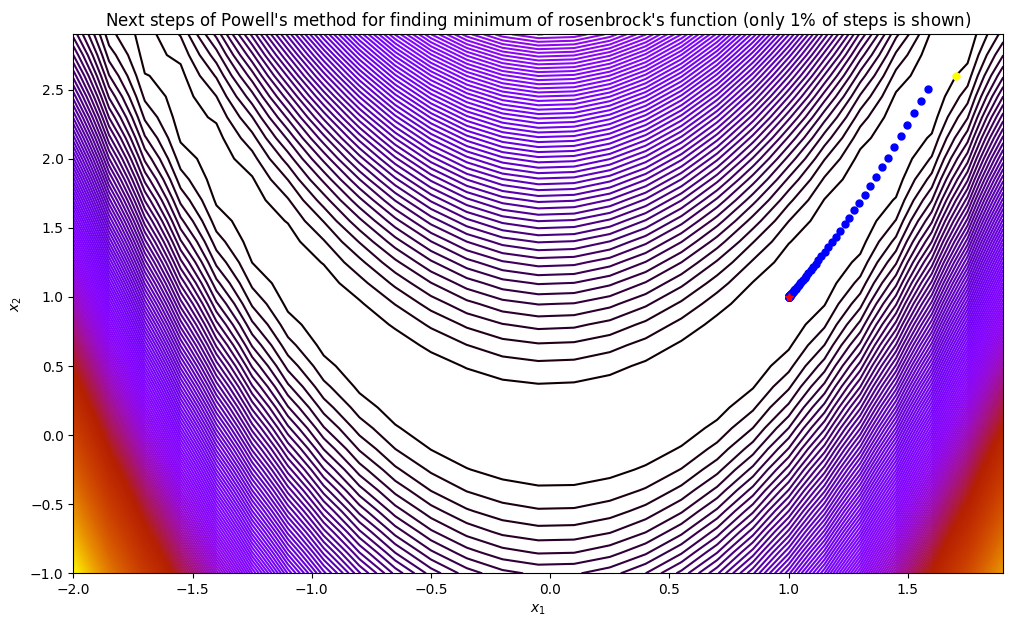

In [174]:
plt.figure(figsize=(12, 7))
plt.contour(X,Y,Z,200, cmap='gnuplot')
plt.plot([x0[0]],[x0[1]], marker='o',markersize=5, color ='yellow')
for i in range(1, len(xs_powell)):
    if i%100 == 0:
        plt.plot([xs_powell[i][0]],[xs_powell[i][1]], marker='o',markersize=5, color ='blue')
plt.plot([min_powell[0]], [min_powell[1]], marker='*', markersize=6, color='red')
plt.title(rf"Next steps of Powell's method for finding minimum of rosenbrock's function (only $1\%$ of steps is shown)")
plt.xlabel(rf"$x_1$")
plt.ylabel(rf"$x_2$")